In [1]:
!nvidia-smi

Mon Aug 24 19:21:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:04:00.0 Off |                  N/A |
| 24%   26C    P8    12W / 180W |   7751MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 00000000:05:00.0 Off |                  N/A |
| 24%   26C    P8     6W / 180W |   7751MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [3]:
import numpy as np
from functools import partial
import tensorflow as tf
import scipy

from scipy.io import loadmat
from keras.layers import Input

from vdae.networks import VDAE, SpectralNet
from vdae.vdae_util import *

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:522: FutureWarning: Passing (type, 1) or 

# DATASET

In [4]:
dataset = 'coil20hr'

if dataset == 'mnist':
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # reshape and standardize x arrays
    x_train = x_train.reshape(len(x_train), -1) / 255
    x_test = x_test.reshape(len(x_test), -1) / 255 
    latent_dim = 10
    bsize = 512
elif dataset == 'coil20hr':
    d_in = scipy.io.loadmat('data/COIL20_UNPROC_128.mat')
    X = d_in['X'] / np.max(d_in['X'])
    Y = d_in['Y']-1
    Y = Y.reshape(-1)
    x_train, x_test = X.reshape((len(X), -1)), X.reshape((len(X), -1))
    y_train, y_test = Y, Y
    latent_dim = 10
    bsize = 256
elif dataset == 'bulldog':
    (x_train, y_train), (x_test, y_test) = generate_bulldog()
    latent_dim = 3
    bsize = len(x_train)
elif dataset == 'loop':
    (x_train, y_train), (x_test, y_test) = generate_loop(n=5000, train_set_fraction=0.85)
    latent_dim = 3
    bsize = len(x_train)
elif dataset == 'faces':
    (x_train, y_train), (x_test, y_test) = generate_faces()
    latent_dim = 5
    bsize = len(x_train)

x_all = np.concatenate([x_train, x_test], axis=0)
    
# normalize to between -1 and 1
if 'mnist' not in dataset and 'cifar' not in dataset and 'bulldog' not in dataset and 'gaussian_grid' not in dataset:
    m, M = np.min(x_train), np.max(x_train)
    a = (M + m) / 2
    b = (M - m) / 2
    x_train, x_test = (x_train - a) / b, (x_test - a) / b

arch = [
    {'type': 'relu', 'size': 500},
    {'type': 'linear', 'size': latent_dim},
    ]

# TRAIN SPECTRALNET

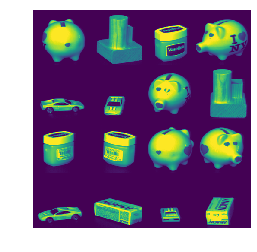

In [5]:
g = plot(x_train, y_train)

In [6]:
n_clusters = latent_dim

batch_sizes = {
    'Unlabeled': bsize,
    'Labeled': bsize,
    'Orthonorm': bsize,
    }

input_shape = x_train.shape[1:]
y_true = tf.placeholder(tf.float32, shape=(None, n_clusters), name='y_true')
y_train_labeled_onehot = np.empty((0, len(np.unique(y_train))))
inputs = {
    'Unlabeled': Input(shape=input_shape, name='UnlabeledInput'),
    'Labeled': Input(shape=input_shape, name='LabeledInput'),
    'Orthonorm': Input(shape=input_shape, name='OrthonormInput'),
    }

In [7]:
spectral_net = SpectralNet(inputs=inputs, arch=arch,
                spec_reg=None, y_true=y_true, y_train_labeled_onehot=y_train_labeled_onehot,
                n_clusters=n_clusters, affinity='full', scale_nbr=3, n_nbrs=12, 
                batch_sizes=batch_sizes, siamese_net=None, 
                x_train=x_train, have_labeled=False)

In [8]:
spectral_net.train(
            x_train, np.zeros_like(x_train[0:0]), x_test,
            lr=1e-5, drop=0.1, patience=20, num_epochs=200)

Epoch: 0, val_loss=2.907794
Epoch: 0, loss=1430.951441, val_loss=25.750566
Epoch: 1, loss=409.963782, val_loss=4.560264
Epoch: 2, loss=326.264424, val_loss=5.549231
Epoch: 3, loss=318.464564, val_loss=4.224104
Epoch: 4, loss=322.200152, val_loss=5.281617
Epoch: 5, loss=322.416240, val_loss=4.730045
Epoch: 6, loss=320.046502, val_loss=4.215975
Epoch: 7, loss=318.371782, val_loss=6.582497
Epoch: 8, loss=321.388316, val_loss=5.390971
Epoch: 9, loss=316.514130, val_loss=4.395044
Epoch: 10, loss=317.130510, val_loss=5.069916
Epoch: 11, loss=316.098988, val_loss=4.702244
Epoch: 12, loss=315.282977, val_loss=4.375641
Epoch: 13, loss=319.217188, val_loss=3.927199
Epoch: 14, loss=314.028844, val_loss=4.224087
Epoch: 15, loss=309.623052, val_loss=3.993936
Epoch: 16, loss=314.532099, val_loss=5.037097
Epoch: 17, loss=313.607289, val_loss=5.388566
Epoch: 18, loss=317.751809, val_loss=6.109742
Epoch: 19, loss=316.464677, val_loss=4.487065
Epoch: 20, loss=316.328147, val_loss=4.455551
Epoch: 21, los

(array([1430.95144081,  409.96378183,  326.26442385,  318.46456385,
         322.20015216,  322.41624045,  320.04650211,  318.37178206,
         321.38831639,  316.51412964,  317.13051009,  316.09898758,
         315.28297663,  319.21718836,  314.02884436,  309.62305164,
         314.53209877,  313.60728884,  317.75180936,  316.46467686,
         316.3281467 ,  313.05806255,  315.29555631,  314.55670428,
         313.59439278,  310.17262554,  315.53676939,  314.48311877,
         312.96327043,  314.37044954,  311.94274211,  312.96644282,
         320.84819865,  308.73721933,  314.32013679,  308.37678552,
         299.52049351,  311.54898977,  300.08914971,  310.02380276,
         305.66597247,  308.67432785,  307.59799266,  304.71474218,
         301.61638713,  309.86272025,  306.43714929,  306.16324687,
         308.61333609,  307.9790988 ,  303.97143126,  302.7359519 ,
         304.19574118,  303.69511962,  301.09585118,  305.46536493,
         304.64095569,  309.92342997,  300.17088

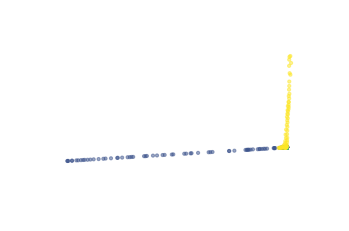

In [9]:
y_pred = spectral_net.predict(x_train)
g = plot(y_pred[:,:3], y_train.reshape(-1,))

In [ ]:
# plot images over embeddings
if 'mnist' in dataset or 'cifar' in dataset or 'coil' in dataset or 'faces' in dataset:
    zoom = 1
    if 'mnist' in dataset:
        img_shape = (28, 28)
    elif 'cifar' in dataset:
        img_shape = (32, 32, 3)
    elif 'coil' in dataset and 'hr' in dataset:
        img_shape = (128, 128)
        zoom = 0.2
    elif 'coil' in dataset:
        img_shape = (32, 32)
    elif 'faces' in dataset:
        img_shape = (28, 20)
        zoom = 2
    _ = imscatter(y_pred[p,0], y_pred[p,1], x_train[p], shape=img_shape, zoom=zoom)

# TRAIN VDAE

In [10]:
svg_bsize = 288
svg_k = 2

svg = VDAE(inputs, spectralnet=spectral_net, orig_dim=x_train.shape[1:], k=svg_k, alpha=1., arch=arch)

IMPORTANT (?, 2)
z_mu_nb (?, 2, 10)
IMPORTANT (?, 2)
important input shape (?, 16384)
NEIGHBORHOOD AND RECON SHAPES: (?, 16384) (?, 16384)


In [ ]:
svg.train(x_train, epochs=5000, batch_size=svg_bsize, full_batch=True)

0 [VAE loss: 21680.39453125] [kl_loss: 11125.595703125] [neighborhood_loss: 261.3235168457031]
vector covariance:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0.58951247 0.51054275 0.5634038  0.5928937  0.6142627  0.392409
  0.7310754  0.47141752 0.5943987  0.3793595 ]]
25 [VAE loss: 1626.117919921875] [kl_loss: 1496.536376953125] [neighborhood_loss: 63.34920883178711]
vector c

100 [VAE loss: 995.6798706054688] [kl_loss: 976.423828125] [neighborhood_loss: 32.383445739746094]
vector covariance:
 [[ 0.96810883 -0.00931176 -0.08050289  0.15031785  0.01697017  0.06522913
   0.03231986  0.14489435  0.01964652  0.08145239]
 [ 0.07719258  0.92654705  0.17213832 -0.11197204  0.1395851  -0.09251647
   0.00604862 -0.08891413  0.0197136  -0.23876368]
 [-0.02447728  0.01570898  0.85719836  0.28195482 -0.13302764  0.11027189
  -0.04255683  0.12752594 -0.06401318  0.3644709 ]
 [-0.14606343  0.18875535 -0.3275059   0.8711577   0.0737192  -0.1153023
  -0.10237339 -0.13057977  0.00531761  0.1748491 ]
 [-0.01804709 -0.15503234  0.13449714  0.02049733  0.9652067   0.13704155
   0.07494266 -0.03164981  0.00878357  0.00548423]
 [-0.08216024  0.16028626 -0.17148486  0.01991753 -0.08425231  0.95577186
  -0.0214586   0.03330815 -0.12327245  0.01974705]
 [-0.06096749  0.06679463 -0.05419658  0.04832935 -0.05495873 -0.02322538
   0.9758982   0.05213775 -0.06282883  0.15474299]
 [-0.15

175 [VAE loss: 956.7215576171875] [kl_loss: 952.4614868164062] [neighborhood_loss: 26.966957092285156]
vector covariance:
 [[ 9.99259233e-01 -1.43633131e-03  1.31266927e-02  4.97966073e-03
   1.82784011e-03  2.52425801e-02  1.37818381e-02 -1.97801329e-02
  -3.29052913e-03  7.03465007e-03]
 [ 1.01203832e-03  9.99208093e-01  1.03588821e-02 -1.86398476e-02
   6.38009375e-03  1.41680147e-02 -8.78596213e-03 -6.41225558e-03
  -2.54034530e-02 -1.10617261e-02]
 [-1.32967317e-02 -9.83324274e-03  9.99433517e-01 -1.86026294e-03
  -6.49285736e-03  9.89410374e-03  6.35958044e-03  1.31161949e-02
   1.16265938e-02  1.91880427e-02]
 [-6.37230137e-03  1.93971097e-02  8.82162887e-04  9.97992456e-01
  -7.00555043e-03  1.61921624e-02  2.13103034e-02 -2.37945188e-02
   1.74218323e-02  4.42551002e-02]
 [-2.22042133e-03 -6.20184653e-03  6.61708461e-03  6.65414333e-03
   9.99713302e-01 -7.88642094e-03  1.29437000e-02 -1.45583665e-02
  -2.96868311e-05 -6.98201708e-04]
 [-2.56851241e-02 -1.45206731e-02 -1.03345

250 [VAE loss: 961.4646606445312] [kl_loss: 949.14697265625] [neighborhood_loss: 22.95148468017578]
vector covariance:
 [[ 9.98785555e-01  6.29354268e-03 -7.70001533e-03  1.27908932e-02
   2.56910361e-02 -8.89674202e-03  1.73338763e-02  2.15893574e-02
   2.35651899e-02  1.01769911e-02]
 [-5.85526926e-03  9.99402165e-01  1.23795969e-02  9.84385237e-03
  -1.49257453e-02  1.16430270e-02  5.53415506e-04 -6.24280889e-03
  -3.70483333e-03  2.23458149e-02]
 [ 8.13508313e-03 -1.16603468e-02  9.99183476e-01 -2.92482004e-02
   1.23474672e-02  6.81958674e-03  1.91067602e-03 -1.13606704e-02
   5.14063193e-03 -1.47020305e-02]
 [-1.17183337e-02 -1.16713382e-02  2.91561056e-02  9.97830153e-01
  -1.20714065e-02  3.81578617e-02  1.42762018e-02 -2.55917292e-02
  -3.52736516e-03  2.71739699e-02]
 [-2.63192002e-02  1.46789597e-02 -1.11504020e-02  1.27841877e-02
   9.98946667e-01 -2.47357618e-02 -2.52181222e-03 -9.88927495e-05
  -2.73172138e-03  1.68517642e-02]
 [ 8.63652211e-03 -1.00632245e-02 -8.99598096

325 [VAE loss: 928.2897338867188] [kl_loss: 926.750732421875] [neighborhood_loss: 20.818449020385742]
vector covariance:
 [[ 9.9922979e-01 -6.7855115e-03  1.5685173e-02  6.1112586e-03
   6.6295238e-03  2.8074422e-04  2.1767875e-02 -1.7744103e-02
   1.9356813e-02 -1.6770287e-03]
 [ 7.2127916e-03  9.9976134e-01 -7.2590858e-03 -2.4588867e-03
   2.5438482e-03  7.1619681e-05 -3.3672948e-03 -5.9533659e-03
  -1.7611405e-02  1.6671792e-03]
 [-1.5680537e-02  7.0970394e-03  9.9949217e-01  3.3692424e-03
  -8.3406428e-03  1.7405261e-03  1.6655312e-03 -1.5365935e-02
  -1.0717342e-02  1.6758308e-02]
 [-5.9990501e-03  2.7211928e-03 -3.3992575e-03  9.9919075e-01
   9.2610493e-03 -8.2867928e-03  9.7951889e-03  2.3667652e-02
   7.8314850e-03  2.6287023e-02]
 [-7.0212390e-03 -2.5902081e-03  8.1802104e-03 -8.4235352e-03
   9.9955213e-01  1.5932100e-02  3.4884259e-03 -1.5555819e-02
  -4.3263640e-03 -1.3220222e-02]
 [ 1.0647880e-04 -2.9479893e-04 -2.2338431e-03  8.1228754e-03
  -1.5715797e-02  9.9963254e-01

400 [VAE loss: 1022.3652954101562] [kl_loss: 902.8070068359375] [neighborhood_loss: 19.0286922454834]
vector covariance:
 [[ 9.99181032e-01  9.55520780e-04 -5.25170425e-03 -1.85174104e-02
   7.90848956e-03  1.19821364e-02 -8.34942982e-03 -2.84118112e-02
   8.48836824e-03 -1.05444854e-02]
 [-2.86111317e-04  9.99680281e-01 -1.90600171e-03  1.62775498e-02
  -5.14168572e-03 -8.90742149e-03 -5.30516822e-03  4.62460984e-03
   1.27859705e-03  1.46227730e-02]
 [ 4.20127902e-03  2.50458065e-03  9.99282718e-01 -1.03900041e-02
   3.94594856e-03  3.05083040e-02  7.66538177e-03 -1.51008423e-02
   7.95088802e-03 -2.49256985e-03]
 [ 1.86947770e-02 -1.60213150e-02  9.92686674e-03  9.99218941e-01
  -1.19722225e-02  1.65626053e-02  1.21932440e-02  3.05557158e-04
  -1.66385528e-02 -3.68970516e-03]
 [-8.03840626e-03  4.88536945e-03 -3.79409082e-03  1.24482485e-02
   9.99768913e-01 -2.54927040e-03 -1.03359800e-02 -9.35342629e-03
   1.79243833e-03  5.36813692e-04]
 [-1.24390302e-02  8.87856074e-03 -3.055342

475 [VAE loss: 907.0994873046875] [kl_loss: 948.38427734375] [neighborhood_loss: 18.266019821166992]
vector covariance:
 [[ 9.99313891e-01 -6.41690101e-04 -8.02479032e-03 -9.11998004e-03
  -5.09527139e-03  5.10355318e-03  7.60863582e-03 -1.54858166e-02
  -2.94978824e-02  1.98001019e-03]
 [ 1.04860484e-03  9.99499857e-01  1.53745906e-02 -1.61453977e-03
   9.13452636e-03  1.42891600e-03  1.48616442e-02  1.05686246e-04
   1.36428503e-02  1.63498148e-02]
 [ 9.33324825e-03 -1.51607823e-02  9.97983694e-01  3.89634334e-02
   5.39610162e-03 -2.52607856e-02 -1.09783299e-02  3.69326025e-02
   5.19610615e-03 -3.78914922e-03]
 [ 6.39534649e-03  2.73698661e-03 -3.61687467e-02  9.95885730e-01
  -1.81957930e-02  4.86591049e-02 -3.34760128e-03 -2.92977411e-02
  -5.41143455e-02  1.89273115e-02]
 [ 6.32234942e-03 -8.99915304e-03 -8.35767016e-03  2.14540623e-02
   9.98581469e-01 -3.24160904e-02  9.75486124e-04  2.65394766e-02
   1.75043680e-02 -1.10170161e-02]
 [-4.69490653e-03 -2.52397778e-03  2.8080862

550 [VAE loss: 981.1438598632812] [kl_loss: 900.936279296875] [neighborhood_loss: 18.191795349121094]
vector covariance:
 [[ 9.99300480e-01  4.38397052e-03  1.97124816e-02  1.08233625e-02
  -9.35802609e-03  2.22078748e-02  4.17171419e-03 -1.22842379e-02
   8.38454720e-03 -7.35922996e-03]
 [-4.40360373e-03  9.99867380e-01  2.43608537e-03 -2.61063711e-03
   5.13093639e-03 -5.56034455e-03  2.69457861e-03 -2.42966483e-03
   1.23122446e-02 -3.33035924e-03]
 [-1.98324118e-02 -2.30378192e-03  9.99223292e-01  2.77002752e-02
   2.26255739e-03  2.98570818e-03  1.91743881e-03  2.95413937e-03
  -6.42359676e-03  1.78634021e-02]
 [-1.00112306e-02  3.06292344e-03 -2.84679700e-02  9.98623252e-01
  -1.37742152e-02 -1.76002516e-03 -1.39273340e-02 -8.90736934e-03
  -2.03712881e-02  3.08295395e-02]
 [ 8.93899053e-03 -5.13646193e-03 -2.32850597e-03  1.43669434e-02
   9.99630690e-01  1.21071087e-02 -2.75676791e-03  6.91941148e-03
   1.25958985e-02 -7.72044342e-03]
 [-2.23458558e-02  5.61523996e-03 -3.508571

625 [VAE loss: 946.3944702148438] [kl_loss: 894.879150390625] [neighborhood_loss: 17.371931076049805]
vector covariance:
 [[ 9.99903917e-01 -1.78482337e-03  1.75974972e-03 -3.83249088e-03
  -4.24668426e-03  3.77758918e-03  1.67472358e-03 -1.03020994e-02
   1.13945454e-03 -5.37840649e-03]
 [ 1.88402936e-03  9.99924839e-01 -8.38918239e-03  4.12889430e-03
  -2.10790592e-03 -4.01077652e-03 -2.78184260e-03  4.04246524e-03
   1.83662365e-03  3.36563610e-03]
 [-2.04892992e-03  8.63621570e-03  9.99386907e-01 -1.39701515e-02
   1.30865555e-02  1.81286391e-02  1.84691860e-03 -1.75680127e-02
   8.24730657e-03 -8.46177060e-03]
 [ 3.93912382e-03 -4.06283699e-03  1.39650991e-02  9.98912334e-01
   1.34115322e-02 -1.23689342e-02  1.87199414e-02  1.63627882e-02
   2.91137770e-02 -1.21824872e-02]
 [ 3.99248209e-03  2.17498583e-03 -1.40146213e-02 -1.28636425e-02
   9.99363422e-01  2.58756746e-02  6.11120777e-04 -1.32313147e-02
   6.39468245e-03  2.10534944e-03]
 [-3.57813085e-03  3.66795622e-03 -1.725196

700 [VAE loss: 905.498779296875] [kl_loss: 900.2845458984375] [neighborhood_loss: 15.846297264099121]
vector covariance:
 [[ 9.98642087e-01 -1.05917361e-03  2.51218844e-02 -1.15938447e-02
   1.16592394e-02 -2.57746666e-03  1.51634368e-03 -3.47009785e-02
   2.40615848e-02  4.42809332e-03]
 [ 1.48910540e-03  9.99869585e-01 -2.71074096e-04 -5.07668476e-04
  -4.96004103e-03  8.15964025e-03  2.75681424e-03  1.14828860e-02
   2.73714634e-03 -4.48634708e-03]
 [-2.56798025e-02  6.55469485e-04  9.99121964e-01  1.54064875e-02
  -2.00603181e-03  4.11405228e-04 -2.22488609e-03 -2.18263175e-02
  -3.70070920e-03  1.89501010e-02]
 [ 1.38703203e-02 -2.52600090e-04 -1.39313657e-02  9.98453915e-01
  -7.89608061e-03  1.40085993e-02  1.11126108e-02  4.75902632e-02
  -5.92646468e-03 -4.60274331e-03]
 [-1.19094905e-02  5.14957076e-03  1.27579912e-03  8.69712699e-03
   9.99787867e-01 -8.37353931e-04 -5.13074547e-03 -1.17060719e-02
  -3.80653283e-03  3.79543955e-04]
 [ 2.58397730e-03 -8.41487478e-03  4.223774

775 [VAE loss: 967.4187622070312] [kl_loss: 906.0164794921875] [neighborhood_loss: 15.925804138183594]
vector covariance:
 [[ 9.99621868e-01 -2.50738836e-03 -1.61139132e-03  7.66072469e-03
   6.44198433e-03  1.72977876e-02 -3.76495929e-03  1.14754727e-02
   1.34287281e-02  4.65159863e-03]
 [ 2.91434652e-03  9.99813139e-01  5.95416874e-03 -3.40789952e-03
  -5.50201954e-03 -9.40881018e-03 -6.66599395e-03 -1.11250952e-02
  -3.79396440e-03 -4.05416405e-03]
 [ 1.53131015e-03 -5.89906098e-03  9.99769211e-01 -6.89761061e-03
   7.03828549e-03  5.23383031e-03  8.35395011e-04  4.93347831e-03
   4.56942100e-04 -1.65800005e-02]
 [-7.37483567e-03  3.24105867e-03  7.21455319e-03  9.99172688e-01
  -5.38203306e-03 -3.19943726e-02  5.42394817e-03  4.28272737e-03
   1.96026955e-02  7.22044054e-03]
 [-6.66230824e-03  5.55857643e-03 -6.64937031e-03  5.48763853e-03
   9.99599576e-01  8.90115462e-03 -5.82772400e-03 -1.43187372e-02
   6.78616809e-03  1.69383734e-02]
 [-1.74402576e-02  9.72386822e-03 -4.77894

850 [VAE loss: 908.5975952148438] [kl_loss: 913.1551513671875] [neighborhood_loss: 16.514225006103516]
vector covariance:
 [[ 9.9937379e-01 -5.4307906e-03 -4.5876522e-03  8.1316596e-03
   1.8318779e-03  1.9722751e-04 -2.7093343e-03  3.2744046e-02
  -7.0970883e-03 -1.4920236e-03]
 [ 5.4304274e-03  9.9988544e-01 -4.8677493e-03 -3.3922412e-03
   5.0842105e-03  1.0696755e-03 -2.7727573e-03 -2.4891361e-03
  -8.8623948e-03 -6.7203394e-03]
 [ 4.7460557e-03  4.8077181e-03  9.9969840e-01 -1.2135168e-02
  -1.0744360e-02  1.3797663e-02  8.8121966e-03 -5.7736121e-04
  -3.0291204e-03 -4.1872528e-03]
 [-8.2754726e-03  3.8304750e-03  1.2772761e-02  9.9877882e-01
   2.8511006e-03 -2.8849917e-02 -9.0764277e-03  1.3482106e-02
   3.2896839e-02  2.7563551e-03]
 [-1.1305955e-03 -5.0997701e-03  1.0357026e-02 -1.7515066e-03
   9.9929696e-01  2.7413581e-02  1.9275371e-03 -2.1032659e-02
  -4.5416751e-03  7.0508416e-03]
 [-2.3101321e-03 -8.7955088e-04 -1.3584773e-02  2.8837267e-02
  -2.6216295e-02  9.9749839e-0

925 [VAE loss: 895.4564208984375] [kl_loss: 921.9053955078125] [neighborhood_loss: 15.349782943725586]
vector covariance:
 [[ 9.99801517e-01  3.96978809e-03  1.30767971e-02  4.80187824e-03
  -8.89958814e-04 -2.14295229e-03 -8.18144763e-04  1.31166065e-02
   3.00135580e-03  2.75183265e-04]
 [-4.07266151e-03  9.99898851e-01  6.86207926e-03 -2.24559335e-03
  -2.91482289e-03  2.01021810e-03  4.79822949e-04  3.72728659e-03
  -7.10953912e-03 -7.50895729e-03]
 [-1.30069982e-02 -6.96901232e-03  9.99761760e-01 -1.26528833e-02
   5.36065362e-03 -6.93585025e-05  6.65727165e-03  2.20182003e-03
   4.86145116e-04 -4.54816734e-03]
 [-5.03027160e-03  2.44887639e-03  1.24809453e-02  9.98759806e-01
   1.20161613e-02 -3.17843594e-02  2.75671505e-03 -6.90409355e-03
   3.24198641e-02 -5.56299184e-03]
 [ 1.10861706e-03  3.07132490e-03 -5.37738763e-03 -1.23133296e-02
   9.99747097e-01 -8.12600018e-04 -9.83364694e-03 -1.06794760e-02
   9.27660987e-03  4.13596677e-03]
 [ 1.50698167e-03 -2.09299242e-03  3.40947

1000 [VAE loss: 946.3353271484375] [kl_loss: 911.1117553710938] [neighborhood_loss: 14.571803092956543]
vector covariance:
 [[ 9.99655902e-01 -8.76555219e-04  2.56563211e-03  1.52211143e-02
  -3.67905828e-03  6.59264950e-03 -1.05542932e-02  1.15629751e-02
  -1.14756599e-02  3.90643254e-03]
 [ 1.00094208e-03  9.99831676e-01  1.08401552e-02 -4.60289232e-03
  -4.82952315e-03  7.89483264e-03  4.04162565e-03 -4.23352094e-03
   7.04097701e-03  5.26254531e-03]
 [-2.91563827e-03 -1.06230341e-02  9.99409974e-01  1.23174861e-02
   6.00589672e-03  1.27488771e-03  1.87974505e-03  2.58032456e-02
   5.22745261e-03 -1.31155346e-02]
 [-1.48674054e-02  4.93254419e-03 -1.25019550e-02  9.98718917e-01
   2.24816450e-03 -3.90817150e-02 -3.77930677e-03  1.02788936e-02
   2.03375816e-02  9.63447895e-03]
 [ 3.82954720e-03  4.76555107e-03 -5.71010308e-03 -2.20051454e-03
   9.99907076e-01  3.86256492e-03 -1.03678287e-03 -7.58492621e-03
   5.13627520e-03  3.34851746e-03]
 [-7.46046938e-03 -7.68676726e-03 -2.1245

1075 [VAE loss: 874.2258911132812] [kl_loss: 916.6976928710938] [neighborhood_loss: 14.392715454101562]
vector covariance:
 [[ 9.99764025e-01  6.28545834e-03  7.99868430e-04 -7.58156367e-03
   1.22858281e-03  1.05314199e-02  7.57890614e-03 -1.31304497e-02
   3.23044788e-03 -4.67446446e-03]
 [-6.11471944e-03  9.99917209e-01 -3.09531996e-03  8.50854348e-03
  -2.94129900e-03 -3.01690353e-03  8.05861608e-04  4.63244086e-03
  -1.18838309e-03  2.24311906e-03]
 [-1.57416146e-03  3.41884070e-03  9.99119997e-01 -1.11068478e-02
   8.01558606e-03  1.99128538e-02  1.89579802e-03 -3.16024609e-02
  -7.94255547e-03 -9.76449251e-03]
 [ 7.94824585e-03 -8.51526670e-03  1.20787313e-02  9.99381721e-01
   7.00489944e-03 -2.22947132e-02  4.48484346e-03  1.33345621e-02
   1.44703779e-02  1.10896549e-03]
 [-1.76164042e-03  3.10587999e-03 -9.24335700e-03 -5.81345381e-03
   9.99214292e-01  3.19161601e-02 -4.45690984e-03 -1.75114907e-02
  -5.60565572e-03  7.89277721e-03]
 [-9.88719147e-03  2.44583143e-03 -1.8629

1150 [VAE loss: 947.0567626953125] [kl_loss: 939.32177734375] [neighborhood_loss: 15.101414680480957]
vector covariance:
 [[ 9.99949574e-01  1.53920951e-03 -2.22885166e-03 -2.38188449e-03
  -4.10236418e-03  2.61009275e-03  1.67745701e-03  7.73072941e-03
   1.00230821e-03  7.00225064e-04]
 [-1.52822013e-03  9.99949038e-01  1.26840814e-03  4.92286356e-03
   4.86760226e-04 -2.96629546e-03 -1.47413835e-03  9.98424366e-04
   2.66934466e-03  7.37665268e-03]
 [ 2.26953439e-03 -1.14324410e-03  9.99689937e-01 -1.26954187e-02
  -4.47223196e-03  1.14235952e-02  3.75301321e-03 -1.64417755e-02
   3.81114241e-03 -1.48854137e-03]
 [ 2.54520494e-03 -4.94038500e-03  1.22420182e-02  9.99619246e-01
   3.59891891e-03  1.10066580e-02  2.69844371e-04 -1.96990818e-02
   4.11370443e-03  6.43200800e-03]
 [ 4.10715071e-03 -5.17853710e-04  4.55887709e-03 -3.58635769e-03
   9.99904394e-01 -4.03298019e-03 -4.64335689e-03  2.43224483e-03
  -7.40285590e-03  6.45940704e-03]
 [-2.51489575e-03  3.02783353e-03 -1.180747

1225 [VAE loss: 958.999755859375] [kl_loss: 880.7020263671875] [neighborhood_loss: 14.49595832824707]
vector covariance:
 [[ 9.99362826e-01 -1.18166320e-02  2.46557537e-02 -1.06129888e-02
   5.48289390e-03 -1.19310385e-02 -2.21113302e-03 -2.21634959e-03
   1.04446420e-02 -1.10499887e-02]
 [ 1.21434964e-02  9.99794424e-01 -5.52010955e-03  9.74864513e-03
  -1.83653296e-03  9.89007857e-03 -3.90618108e-03 -4.12160205e-03
   2.07949826e-03 -6.15383091e-04]
 [-2.43445709e-02  5.73717523e-03  9.99145627e-01 -9.55472514e-03
  -4.85276897e-03  9.68362018e-03  1.81589904e-03 -2.45988481e-02
  -1.12347109e-02  1.17960796e-02]
 [ 9.77369584e-03 -9.32563003e-03  1.07330065e-02  9.98671651e-01
   2.63213622e-03 -3.82802635e-02  9.54768527e-03  1.91325825e-02
   1.70531031e-02  1.17013613e-02]
 [-5.45604248e-03  1.58985693e-03  3.70405708e-03 -1.15045824e-03
   9.99191105e-01  1.88082680e-02 -3.50398244e-03 -3.45768370e-02
  -2.39945235e-04 -2.87490455e-03]
 [ 1.27678476e-02 -1.02746794e-02 -8.182704

1300 [VAE loss: 916.8621826171875] [kl_loss: 959.6160888671875] [neighborhood_loss: 15.546502113342285]
vector covariance:
 [[ 9.99829710e-01  4.06354899e-03 -4.89257602e-03  1.88789505e-03
  -2.44765286e-03  1.45682404e-02 -3.70592764e-03  2.50097760e-03
  -2.22021644e-03  7.30680954e-03]
 [-3.84835643e-03  9.99858975e-01  7.09615834e-03 -3.97065701e-03
   7.98647851e-03 -6.19184133e-03  1.25257904e-03 -1.46843819e-03
  -4.18162905e-03 -8.82533193e-03]
 [ 4.97944886e-03 -6.95717009e-03  9.98798430e-01  2.12444197e-02
  -3.18691810e-03 -1.49030900e-02 -1.15167559e-03  4.02178019e-02
   4.87692608e-03  1.57527463e-03]
 [-1.86846964e-03  4.19198303e-03 -2.22684033e-02  9.99360383e-01
  -5.52607002e-03 -1.44246947e-02 -1.03320612e-03  1.85840596e-02
   1.26408460e-02  4.10630926e-03]
 [ 2.48870673e-03 -8.00008886e-03  2.90088262e-03  5.63569367e-03
   9.99913037e-01 -1.67554792e-03  3.17926798e-03  2.71564792e-03
  -6.40755380e-03  1.43082708e-03]
 [-1.46379042e-02  6.17865752e-03  1.5039

1375 [VAE loss: 898.6602172851562] [kl_loss: 933.018798828125] [neighborhood_loss: 15.231870651245117]
vector covariance:
 [[ 9.9976528e-01  2.3545430e-03 -1.4754233e-02  1.1328449e-03
  -6.6700410e-03  9.6040806e-03 -1.7576852e-03 -9.7054224e-03
   1.0832263e-03  3.1142903e-03]
 [-2.3167487e-03  9.9991405e-01  1.8335189e-03 -9.4766583e-04
   2.9010032e-03 -3.1038830e-03 -9.7643828e-04 -2.3925121e-04
   8.7311473e-03  8.1875026e-03]
 [ 1.4795890e-02 -1.7994071e-03  9.9942964e-01 -1.0957986e-02
   1.7596493e-02  7.8116846e-03  1.0109477e-03 -5.4647718e-03
   1.1234738e-02 -1.6438728e-02]
 [-1.1179694e-03  8.3829707e-04  1.1360050e-02  9.9977267e-01
  -8.1817117e-03  2.4320846e-03  4.6445228e-05 -2.6598852e-03
  -1.2504023e-03  1.5555382e-02]
 [ 6.3939854e-03 -2.9407465e-03 -1.7528346e-02  8.2857730e-03
   9.9963814e-01  6.3194595e-03 -9.0272175e-03  9.5038852e-03
   5.1611057e-03  7.7394894e-03]
 [-9.7918017e-03  3.1263123e-03 -7.6434496e-03 -2.3941975e-03
  -6.2601585e-03  9.9986899e-0

1450 [VAE loss: 932.8643798828125] [kl_loss: 919.9321899414062] [neighborhood_loss: 14.291308403015137]
vector covariance:
 [[ 9.99855757e-01  2.44006724e-03 -2.49804743e-03 -1.06228795e-03
  -1.22477785e-02  6.71437476e-03 -2.61525391e-04 -6.13168161e-03
   6.05103839e-03  2.34096474e-03]
 [-2.31847563e-03  9.99852538e-01  3.88664426e-03 -5.94561407e-03
   6.20090449e-03  3.81568214e-03  5.43604081e-04 -2.78380397e-03
  -1.31864678e-02 -2.05298746e-03]
 [ 2.79280404e-03 -3.59712914e-03  9.99343693e-01  9.43715684e-03
  -3.13063356e-04 -2.22458523e-02 -1.17281592e-03  2.60058325e-02
   5.18404087e-03 -1.64505537e-03]
 [ 8.99580482e-04  5.89079922e-03 -9.20447521e-03  9.99658823e-01
  -1.00440979e-02  5.82034048e-03 -1.07951695e-02 -7.28153391e-04
  -1.22457556e-02  1.26655959e-02]
 [ 1.23861572e-02 -5.93132526e-03 -5.17939101e-04  1.02911303e-02
   9.99605954e-01 -5.99234644e-03  1.91787828e-03  1.90695431e-02
   8.36185366e-03 -4.47251787e-03]
 [-6.66129915e-03 -3.96444928e-03  2.2592

1525 [VAE loss: 905.7880859375] [kl_loss: 940.1708374023438] [neighborhood_loss: 14.328216552734375]
vector covariance:
 [[ 9.99556661e-01 -5.61223458e-03  1.69658829e-02 -8.98902304e-03
   1.07300654e-02 -1.49187418e-02  2.30685924e-03  1.10118977e-04
   1.15714399e-02 -3.06795700e-03]
 [ 5.83578832e-03  9.99891639e-01 -6.35926053e-03  8.88538454e-03
  -2.84563098e-03  3.06102773e-03  3.26869357e-03 -8.88090464e-04
   4.11747443e-03  4.14841529e-03]
 [-1.68542005e-02  6.59032399e-03  9.99140680e-01 -1.32444967e-02
   5.99064119e-03  8.99488945e-03 -8.05934984e-03 -3.11053395e-02
  -8.06970336e-03  4.73048247e-04]
 [ 7.64795486e-03 -8.72961152e-03  1.41066145e-02  9.98595357e-01
   1.80158038e-02 -3.94202657e-02 -2.23176065e-03  8.68607778e-03
   2.26527080e-02 -1.30977051e-03]
 [-1.02814753e-02  2.92290724e-03 -7.49618560e-03 -1.64466668e-02
   9.99088764e-01  2.32996084e-02  4.17344552e-03 -2.72086058e-02
  -8.81911069e-03  1.47485745e-03]
 [ 1.57512296e-02 -3.55906528e-03 -6.9534536

1600 [VAE loss: 918.6168212890625] [kl_loss: 911.8994750976562] [neighborhood_loss: 15.264683723449707]
vector covariance:
 [[ 9.99663174e-01 -6.74780831e-03  1.12715794e-03 -3.99726490e-03
   5.96808642e-03 -7.61092361e-03  7.02292426e-03 -2.12920792e-02
   3.71902040e-03 -7.67568068e-04]
 [ 6.87226234e-03  9.99888539e-01 -2.13887403e-03 -1.28113653e-03
   1.54940656e-03  5.87432412e-03  9.81829129e-04  4.95239953e-03
   4.20466671e-03  9.45589319e-03]
 [-1.43123837e-03  2.23745662e-03  9.99801636e-01 -6.51780330e-03
   5.47953881e-03 -8.75138957e-03 -8.31881072e-03 -1.04455017e-02
   7.41190417e-03 -2.71902210e-03]
 [ 4.01225779e-03  1.13598444e-03  6.88015344e-03  9.99257326e-01
  -8.46287992e-04  3.38544324e-02  1.31579675e-02 -8.13490152e-03
  -5.61371678e-03 -1.60064129e-03]
 [-5.67655452e-03 -1.55952037e-03 -5.27846813e-03  9.88199725e-04
   9.99846160e-01 -9.71139292e-04  3.41595337e-03  1.45532098e-02
  -4.22586827e-03 -1.35807565e-03]
 [ 7.01428205e-03 -5.88759081e-03  8.3023

1675 [VAE loss: 867.7315673828125] [kl_loss: 967.6605224609375] [neighborhood_loss: 14.808518409729004]
vector covariance:
 [[ 9.99514461e-01  1.08642562e-03 -4.89229383e-03  5.89699904e-03
  -3.78374010e-03  1.96365174e-02 -2.74195103e-03 -1.92361437e-02
   1.12617770e-02  2.54284847e-03]
 [-1.07269164e-03  9.99920666e-01 -4.78573143e-03 -9.43735766e-04
   7.57175451e-03 -1.32455700e-03 -6.17987150e-03 -2.61546392e-03
  -2.91925133e-03 -4.60573379e-03]
 [ 4.78181336e-03  4.94570145e-03  9.99665260e-01  1.09043205e-02
  -1.09455381e-02  9.34754964e-03  5.28906286e-03  2.82315561e-03
  -1.24849575e-02  1.02083590e-02]
 [-5.61705697e-03  1.02530839e-03 -1.10296980e-02  9.99451756e-01
  -3.29554692e-04  7.34891882e-03  1.95298623e-03  2.86843181e-02
   5.60206873e-03  5.45802666e-03]
 [ 3.89223290e-03 -7.55683798e-03  1.09972553e-02  4.73150722e-04
   9.99886096e-01 -1.95700515e-04 -4.24215058e-03  1.54585496e-03
  -1.52059295e-03 -3.40692489e-03]
 [-1.92565471e-02  1.25321653e-03 -9.4342

1750 [VAE loss: 892.5836791992188] [kl_loss: 927.5372924804688] [neighborhood_loss: 14.22650146484375]
vector covariance:
 [[ 9.9983281e-01  2.8296481e-03 -5.5051520e-03 -1.3809548e-02
  -5.2034529e-03  5.2131149e-03 -6.0544913e-05  2.7296641e-03
  -6.6139563e-03 -9.2146809e-05]
 [-2.6557229e-03  9.9988925e-01  3.6717101e-04  7.3508560e-03
   5.5458387e-03  3.7620220e-04  1.4802236e-03  3.3549666e-03
   7.8575779e-03  7.3725176e-03]
 [ 5.6018545e-03 -4.8812068e-04  9.9960357e-01 -2.2312773e-03
   5.1629674e-03 -2.0792787e-03  9.2348881e-04  1.4623025e-02
   1.9727828e-02 -1.1011997e-02]
 [ 1.3730759e-02 -7.1482961e-03  2.2046962e-03  9.9948841e-01
  -5.9002098e-03  1.9545438e-02  5.3687138e-03 -1.0303441e-02
  -1.4120154e-04 -1.5040679e-02]
 [ 5.2632671e-03 -5.6725051e-03 -5.5448976e-03  5.9871785e-03
   9.9977076e-01 -9.8815560e-04  1.7511597e-03  1.7356060e-02
   5.1670875e-03 -2.3614102e-04]
 [-5.3091911e-03 -1.1500823e-04  2.6309362e-03 -1.9952524e-02
   1.9254683e-03  9.9872172e-0

1825 [VAE loss: 952.9572143554688] [kl_loss: 898.9080810546875] [neighborhood_loss: 14.26763916015625]
vector covariance:
 [[ 9.9987411e-01 -3.8761324e-03 -3.5717932e-03 -1.5970535e-03
  -7.0452513e-03  1.2628549e-02 -3.2618683e-04 -3.1151965e-03
   1.1698353e-03 -7.0555013e-04]
 [ 3.7052699e-03  9.9983919e-01  1.8449145e-03 -5.3541218e-03
  -4.6764156e-03  8.4998533e-03 -4.0568355e-03 -5.9615234e-03
   1.0358110e-02  4.7078896e-03]
 [ 3.6164552e-03 -1.8091219e-03  9.9992692e-01 -5.3643872e-04
  -1.9771673e-03 -3.8828903e-03  3.1062830e-03  7.8882808e-03
   4.7991397e-03 -3.9257547e-03]
 [ 9.7595394e-04  4.9873330e-03  9.2465553e-04  9.9872184e-01
  -1.5106407e-02  3.7956394e-02 -1.3612532e-03 -2.3765057e-02
  -1.6993193e-02 -1.9038271e-03]
 [ 7.4103521e-03  4.9167569e-03  1.6977532e-03  1.6498001e-02
   9.9937689e-01 -2.1615721e-02 -1.5856692e-03  1.8061824e-02
   9.7768763e-03 -2.1753703e-04]
 [-1.2649635e-02 -8.7598767e-03  4.1376720e-03 -3.8301494e-02
   2.2940865e-02  9.9817157e-0

1900 [VAE loss: 930.4514770507812] [kl_loss: 941.2747192382812] [neighborhood_loss: 14.996631622314453]
vector covariance:
 [[ 9.9981725e-01 -4.0776762e-03 -9.0468209e-03 -1.3613571e-02
  -4.7419588e-03  6.9476007e-03 -2.0756980e-03  1.9450533e-03
   3.9635374e-06  1.7317090e-03]
 [ 4.0078778e-03  9.9995250e-01 -4.8512192e-03  3.3716040e-04
   1.7906595e-03  2.7391617e-03 -3.0331931e-03  4.4394294e-03
  -2.2910114e-03  3.2382831e-03]
 [ 9.1133490e-03  4.7747265e-03  9.9973047e-01  1.1894353e-02
  -9.7448174e-03  8.7726684e-03  5.0513013e-03  9.5440857e-03
  -1.6262630e-03 -7.3370605e-04]
 [ 1.3365060e-02 -5.2141468e-04 -1.2324475e-02  9.9964422e-01
  -8.4375227e-03  1.1066252e-02  1.9209932e-03  1.1556584e-02
  -6.8581393e-03 -1.6480300e-03]
 [ 4.9133860e-03 -1.7610944e-03  9.6044717e-03  8.5054822e-03
   9.9988455e-01  3.9430284e-03  4.8807744e-04 -2.6714522e-03
   3.6500196e-03  1.7232023e-03]
 [-7.1997112e-03 -2.7407794e-03 -8.4387669e-03 -1.0964649e-02
  -3.7628952e-03  9.9965107e-

1975 [VAE loss: 937.9977416992188] [kl_loss: 853.6046142578125] [neighborhood_loss: 14.91180419921875]
vector covariance:
 [[ 9.99532044e-01 -4.79262369e-03 -1.18495738e-02 -2.10510436e-04
  -3.82316275e-03 -9.63406451e-03  4.34895250e-04  1.29528046e-02
  -2.21614446e-02 -2.38283793e-03]
 [ 5.08848391e-03  9.99890268e-01  1.66304957e-03  1.78626855e-03
  -5.35585033e-03 -1.82663120e-04 -5.27323224e-03 -6.50807004e-03
   9.38616414e-03  6.80832309e-04]
 [ 1.19110467e-02 -1.62807235e-03  9.99626279e-01 -1.40599674e-04
   5.87498583e-03  1.09732701e-02  4.15144116e-03  1.71169881e-02
   8.27706605e-03 -8.29279236e-03]
 [ 5.55921812e-04 -1.87586434e-03  2.20914459e-04  9.99849200e-01
   5.09000337e-03  5.21317776e-03  3.89861176e-03 -1.43303890e-02
   4.60071489e-03 -1.67447713e-03]
 [ 3.85570317e-03  5.35302237e-03 -5.97985787e-03 -5.11657959e-03
   9.99797285e-01  1.50572583e-02 -6.63201604e-03 -5.19950583e-04
  -3.87411751e-03  3.72066605e-03]
 [ 9.51700564e-03  7.73094289e-05 -1.11684

2050 [VAE loss: 922.9530639648438] [kl_loss: 872.299072265625] [neighborhood_loss: 13.971550941467285]
vector covariance:
 [[ 9.99818861e-01 -4.20991378e-03  4.60817479e-03 -1.09296935e-02
   7.17415661e-03 -3.86782049e-04  3.17843421e-03 -6.03602733e-03
   1.02905044e-02  2.20524729e-04]
 [ 4.29982878e-03  9.99931157e-01 -2.60915840e-03  3.31949838e-03
  -5.42049157e-03  7.21121393e-03 -3.68037447e-03  1.42522121e-03
   2.02072272e-03  6.48948422e-04]
 [-4.87694563e-03  2.65400019e-03  9.99552667e-01 -1.26240738e-02
   5.38415369e-03  1.04295891e-02 -1.59545557e-03 -2.30962504e-02
  -2.59799743e-03  4.89657745e-03]
 [ 1.10743418e-02 -3.38035473e-03  1.29909320e-02  9.99648988e-01
  -6.14986708e-03  4.64643026e-03  5.22748334e-03  1.45467222e-02
  -1.00536263e-02  6.60472724e-05]
 [-7.20527722e-03  5.41817863e-03 -5.55879064e-03  6.54128799e-03
   9.99770999e-01 -2.11565336e-03  7.57936912e-04 -8.45148228e-03
   9.16897412e-03  1.19394539e-02]
 [ 3.14659061e-04 -7.21792923e-03 -1.05423

2125 [VAE loss: 897.6728515625] [kl_loss: 833.7344970703125] [neighborhood_loss: 13.600947380065918]
vector covariance:
 [[ 9.9991310e-01 -2.4042055e-03 -3.6469853e-04 -7.7237543e-03
   2.6982925e-03  6.9222827e-03 -5.8748638e-03 -3.1870995e-03
  -1.1005573e-03  2.7233451e-03]
 [ 2.4611519e-03  9.9994731e-01 -1.4999777e-03  5.8934549e-03
  -5.1393788e-03  4.6125296e-04  7.3428691e-04 -2.3712728e-03
  -4.2974823e-03 -3.3023404e-03]
 [ 1.7244708e-04  1.6514482e-03  9.9965799e-01 -2.0565007e-02
   8.1644552e-03  6.2614107e-03  3.9593978e-03 -6.4923204e-03
   7.3072873e-03 -6.4041410e-03]
 [ 8.0962963e-03 -5.6538642e-03  2.0461854e-02  9.9780887e-01
   1.3479295e-02 -4.9863670e-02  2.1411444e-03  4.4632507e-03
   3.3150394e-02 -8.3502624e-03]
 [-2.9103472e-03  5.1674396e-03 -8.6419741e-03 -1.2879312e-02
   9.9961334e-01  8.0735069e-03 -9.6727803e-04 -2.0544706e-02
   2.9946703e-03 -4.3555998e-04]
 [-6.4607789e-03 -8.0949778e-04 -4.6319631e-03  5.1090311e-02
  -6.7067142e-03  9.9757606e-01 

2200 [VAE loss: 869.2176513671875] [kl_loss: 918.1555786132812] [neighborhood_loss: 15.111568450927734]
vector covariance:
 [[ 9.99153376e-01 -9.43747722e-03  6.49606716e-03 -3.06897350e-02
   1.43770771e-02 -1.26489270e-02  1.22156739e-02 -1.77318824e-03
   8.52664409e-04 -9.98693053e-03]
 [ 1.00384858e-02  9.99763131e-01 -2.52909237e-03  1.44072426e-02
  -1.05005121e-02  2.13211100e-03  3.87395313e-03  1.26765994e-03
   5.21048997e-03  7.72066822e-04]
 [-6.69839978e-03  2.81472853e-03  9.99650240e-01 -7.89622311e-03
   7.70784868e-03  1.23145431e-02 -5.93673391e-03 -1.69811212e-02
  -2.81545872e-05 -7.06586987e-03]
 [ 2.95126047e-02 -1.45746572e-02  8.93516745e-03  9.97563362e-01
   1.54194757e-02 -3.98130491e-02  5.65185538e-03  3.13743092e-02
   2.37709917e-02 -1.73162781e-02]
 [-1.44047840e-02  1.08287558e-02 -8.63521546e-03 -1.30925309e-02
   9.99083042e-01  1.39403725e-02 -3.56810284e-03 -3.20716836e-02
  -5.96129976e-04  5.13906591e-03]
 [ 1.40492879e-02 -3.07827163e-03 -1.1218

2275 [VAE loss: 901.1367797851562] [kl_loss: 886.2640380859375] [neighborhood_loss: 13.391641616821289]
vector covariance:
 [[ 9.9986267e-01 -4.5836596e-03  1.7657970e-03 -5.8483779e-03
   1.5426419e-03  1.7042304e-03 -1.4546660e-03  1.4413719e-02
   1.0449897e-03  4.5184864e-04]
 [ 4.6683643e-03  9.9992818e-01  4.4488537e-04  4.6919021e-03
   7.5037777e-04 -2.0517586e-03 -3.4899616e-03 -4.3723700e-03
   5.1328563e-03 -6.0960902e-03]
 [-1.7580121e-03 -4.1931166e-04  9.9996853e-01 -9.9693995e-04
  -1.9291297e-03 -1.9887694e-04  6.6003744e-03  1.0624144e-05
  -1.3957900e-03 -3.0626343e-03]
 [ 5.5400161e-03 -4.9404064e-03  1.0567356e-03  9.9739212e-01
   1.4484777e-02 -5.9015866e-02 -1.8818948e-03  2.1863176e-02
   3.0809348e-02 -5.4269014e-03]
 [-1.2283229e-03 -7.4388093e-04  1.8677738e-03 -1.2444813e-02
   9.9922687e-01  1.7260786e-02  2.3239825e-04 -2.7892428e-02
  -1.5470623e-02 -8.3699990e-03]
 [-1.9147623e-03  2.0091622e-03  2.7463934e-04  5.8631282e-02
  -1.5461954e-02  9.9725240e-

2350 [VAE loss: 928.8953857421875] [kl_loss: 858.6063842773438] [neighborhood_loss: 13.286352157592773]
vector covariance:
 [[ 9.9946755e-01 -5.9769475e-03  1.2366037e-02 -2.8514536e-03
   8.6380839e-03 -1.5610476e-02 -4.2336839e-03  2.1756552e-02
   7.4837483e-03 -1.6448457e-03]
 [ 6.1045764e-03  9.9991369e-01  1.5780922e-03  4.3929368e-03
   3.6544772e-04  5.1025483e-03 -3.0967898e-03 -3.4971770e-03
  -7.6249975e-04 -8.0748545e-03]
 [-1.2304859e-02 -1.5163983e-03  9.9985981e-01  1.5307857e-03
   1.8815660e-03  4.1567166e-03 -5.4743153e-04  2.3689833e-03
  -9.6877506e-03  2.0032772e-03]
 [ 1.4594645e-03 -4.1727168e-03 -1.1478089e-03  9.9845070e-01
   1.6464250e-02 -4.1147817e-02  3.4626035e-03  1.8296696e-02
   2.5924571e-02 -9.5926141e-03]
 [-7.6133348e-03 -4.7628541e-04 -2.0618415e-03 -1.5006262e-02
   9.9907947e-01  1.2398145e-02  3.3178034e-03 -3.3375531e-02
  -1.5573085e-02 -5.5937357e-03]
 [ 1.4881994e-02 -5.1092566e-03 -4.2153010e-03  4.0658053e-02
  -1.0190112e-02  9.9782467e-

2425 [VAE loss: 920.9969482421875] [kl_loss: 931.0133056640625] [neighborhood_loss: 14.669974327087402]
vector covariance:
 [[ 9.9986279e-01 -1.9160745e-03 -1.2144577e-02  1.3581843e-03
  -1.9310445e-03  3.0660490e-03  1.2457788e-03  9.3829911e-03
  -1.3689828e-03  4.1247024e-03]
 [ 1.9080591e-03  9.9997503e-01 -1.2091529e-03  2.4121453e-03
  -4.3343427e-03  1.5544570e-03  2.5141805e-03 -2.7938497e-03
  -1.8013557e-03 -5.0226721e-04]
 [ 1.2111804e-02  1.1915526e-03  9.9975497e-01 -7.2114062e-03
   6.5745078e-03  1.3844079e-02  6.4987675e-03  1.2057822e-03
  -2.5304318e-03 -2.2343637e-03]
 [-1.1263028e-03 -2.2266177e-03  7.6077194e-03  9.9899071e-01
   1.8358437e-02 -3.5400428e-02  2.0788407e-03  4.4793701e-03
   1.7843677e-02 -4.5399936e-03]
 [ 1.9266953e-03  4.3052337e-03 -7.0320214e-03 -1.7369643e-02
   9.9941254e-01  2.3690239e-02 -7.0041451e-03 -8.5259825e-03
  -4.6835011e-03 -9.8214485e-03]
 [-3.6830313e-03 -1.6934056e-03 -1.3441506e-02  3.6126856e-02
  -2.2827988e-02  9.9826992e-

2500 [VAE loss: 855.9481201171875] [kl_loss: 910.9229125976562] [neighborhood_loss: 13.64372730255127]
vector covariance:
 [[ 9.99559045e-01 -1.31263596e-03  8.29888228e-03 -1.54321352e-02
   1.35659939e-02 -4.22495371e-03 -2.26734905e-03  7.80078303e-03
   1.57931577e-02 -7.46655697e-03]
 [ 1.72230182e-03  9.99783337e-01  1.16914837e-03  8.62615835e-03
  -1.09653166e-02  1.16380579e-04  3.39382188e-03  3.15546431e-03
  -1.29182469e-02 -6.77780807e-03]
 [-8.74337461e-03 -8.58479470e-04  9.99614179e-01 -1.87635422e-02
   7.10280286e-03 -1.47743765e-02 -6.48819900e-04 -7.95417931e-03
   2.80533475e-03 -1.43278146e-03]
 [ 1.43456040e-02 -8.52222741e-03  1.83319189e-02  9.97856438e-01
   4.33798693e-03 -4.56624925e-02 -4.38024709e-03  3.27107608e-02
   1.88337751e-02 -1.09789567e-02]
 [-1.31261302e-02  1.11377509e-02 -7.44761899e-03 -2.50100624e-03
   9.99198914e-01  3.44172469e-03 -1.31435052e-03 -3.37205976e-02
  -3.50824092e-03  8.97114817e-03]
 [ 4.76718508e-03 -9.55185213e-04  1.60162

2575 [VAE loss: 939.2481079101562] [kl_loss: 867.9567260742188] [neighborhood_loss: 14.093141555786133]
vector covariance:
 [[ 9.99252379e-01 -8.20000563e-03 -8.26126058e-03  5.32168336e-03
  -1.41453771e-02  1.75429564e-02  4.59437910e-03 -1.31042823e-02
  -2.33829301e-02  9.12631676e-03]
 [ 8.22596438e-03  9.99672890e-01 -2.05136393e-03  2.47771665e-03
  -3.40752047e-03  7.43015856e-03 -8.68661737e-04 -1.01608150e-02
   1.85070727e-02  7.92710390e-03]
 [ 8.27363692e-03  2.23904848e-03  9.98143315e-01  4.13366668e-02
  -1.90953501e-02 -5.33636333e-03 -2.77068210e-03  3.84825021e-02
  -2.57969601e-03  6.25333702e-03]
 [-8.13345145e-03 -2.45288410e-03 -4.14721109e-02  9.96119082e-01
  -2.94089057e-02  5.88597283e-02 -5.83933527e-03 -3.66981723e-03
  -3.80560569e-02  1.13769667e-02]
 [ 1.49494717e-02  3.40799964e-03  1.63063407e-02  3.11329477e-02
   9.98561382e-01 -5.50061837e-03 -3.21357721e-03  3.51246968e-02
   1.12487115e-02  1.99685548e-03]
 [-1.71794761e-02 -8.03252123e-03  1.0262

2650 [VAE loss: 933.6321411132812] [kl_loss: 924.8818359375] [neighborhood_loss: 13.948492050170898]
vector covariance:
 [[ 9.9970931e-01 -9.2535838e-03 -9.9929806e-04 -1.5261978e-02
  -1.6826476e-03  7.0132287e-03 -3.7495950e-03 -7.7685127e-03
  -1.0222914e-02 -5.5242241e-03]
 [ 9.5343739e-03  9.9977010e-01 -7.5608869e-03  6.5869531e-03
  -3.6704510e-03 -8.7441609e-04 -6.6951550e-05  6.3045893e-04
   1.5052732e-02  5.2037812e-03]
 [ 1.1920752e-03  7.4104867e-03  9.9988973e-01  6.3876486e-03
   5.2034308e-04  3.1985177e-03  1.4074511e-03 -5.7295165e-03
   4.3864823e-03  7.6739616e-03]
 [ 1.4445558e-02 -6.2415106e-03 -6.3086404e-03  9.9852186e-01
  -1.8527856e-02  2.9584860e-02 -4.7006821e-03 -1.1731606e-02
  -3.5675146e-02 -3.9581624e-03]
 [ 2.3008655e-03  3.3594563e-03 -5.8687531e-04  1.9402958e-02
   9.9956501e-01 -1.3562230e-02 -2.5850360e-03  1.4512362e-02
   8.6127874e-03  9.8140829e-04]
 [-7.5412858e-03  9.8140200e-04 -3.3021846e-03 -2.9202072e-02
   1.4506409e-02  9.9877888e-01 

2725 [VAE loss: 929.8760986328125] [kl_loss: 908.1045532226562] [neighborhood_loss: 13.902109146118164]
vector covariance:
 [[ 9.9982047e-01  2.9975013e-03 -6.5796422e-03 -6.8289326e-03
  -3.5454596e-03 -3.5198310e-03 -2.5432900e-04 -1.2293804e-02
  -8.2432497e-03  4.0303930e-03]
 [-2.8540606e-03  9.9994469e-01  3.0347281e-03  9.9784380e-04
  -2.6750879e-03  2.5054899e-03 -1.5822180e-03  4.8730224e-03
   4.1245380e-03 -5.9808539e-03]
 [ 6.6830814e-03 -3.0627414e-03  9.9987584e-01 -4.9158069e-03
   1.7389642e-03 -2.8792623e-04 -2.4440670e-03  2.0972975e-03
   1.2449781e-02  1.3238963e-03]
 [ 6.6343872e-03 -9.9189254e-04  5.2021835e-03  9.9905622e-01
  -1.5869714e-02  3.0658457e-02 -3.6835473e-03 -6.9104689e-03
  -2.3691123e-02 -7.3573290e-04]
 [ 3.8868072e-03  2.6000636e-03 -1.7731604e-03  1.6304940e-02
   9.9960124e-01 -6.2082489e-03  1.8874657e-03  2.0751571e-02
   4.0702531e-03  4.1757696e-03]
 [ 3.0564645e-03 -2.3421161e-03  2.5369397e-06 -3.0453758e-02
   7.3146187e-03  9.9887437e-

2800 [VAE loss: 935.2197875976562] [kl_loss: 863.2960815429688] [neighborhood_loss: 13.705554962158203]
vector covariance:
 [[ 9.99758303e-01 -6.02633227e-03  5.56296343e-03  1.17047196e-02
  -2.95368629e-03  4.33678832e-03 -3.90450703e-03  1.39584607e-02
   5.15419105e-03  3.82229313e-03]
 [ 6.08911971e-03  9.99938071e-01 -1.98899861e-03  1.24642882e-03
   1.20197423e-03 -1.43939815e-03  1.72763306e-03 -5.27861994e-03
   6.46859407e-03 -2.22343602e-03]
 [-5.57478052e-03  2.09475588e-03  9.99805987e-01  3.29836807e-03
  -5.52823767e-03  1.31439008e-02  5.11785364e-03 -4.04761755e-04
  -1.03267496e-02 -2.32937397e-03]
 [-1.17111662e-02 -1.47224532e-03 -2.23275344e-03  9.97644484e-01
   2.52434276e-02 -4.83739749e-02  7.77466036e-03  1.17629655e-02
   3.71809788e-02 -1.66623201e-03]
 [ 3.48398485e-03 -1.15182961e-03  5.23057859e-03 -2.34002061e-02
   9.99097943e-01  1.77717879e-02 -9.85872932e-03 -2.06503961e-02
  -1.77119337e-02 -7.84842949e-03]
 [-5.47527755e-03  1.81464781e-03 -1.3544

2875 [VAE loss: 886.996337890625] [kl_loss: 876.3079223632812] [neighborhood_loss: 13.410948753356934]
vector covariance:
 [[ 9.9980956e-01 -3.2109960e-03 -7.3762024e-03 -3.5562571e-03
   3.8891498e-04 -1.1499529e-03  2.5634046e-04  2.9579925e-03
  -1.7118175e-02 -3.0109484e-04]
 [ 3.2317587e-03  9.9991995e-01  4.9477834e-03 -2.1876378e-03
   6.6894507e-03  1.3912484e-03  6.9291070e-03  4.0857368e-03
   3.3575771e-04  2.9653378e-03]
 [ 7.4227778e-03 -4.9733091e-03  9.9978018e-01 -7.2705136e-03
  -5.5163313e-04 -1.1153173e-02 -1.9957691e-03  8.8635487e-03
   7.5222887e-03 -6.5563875e-03]
 [ 3.7061474e-03  2.0641265e-03  7.1194083e-03  9.9988258e-01
   6.5749534e-03 -7.6883626e-03  3.9262222e-03  2.3640434e-03
   6.3927285e-03  1.3327035e-03]
 [-4.7455376e-04 -6.7315972e-03  5.7700876e-04 -6.5101744e-03
   9.9991888e-01  5.7791197e-03  4.7663716e-03 -1.8863447e-03
  -3.2431413e-03 -1.8967924e-03]
 [ 1.3963446e-03 -1.4344432e-03  1.1216082e-02  7.5778584e-03
  -5.7173925e-03  9.9981177e-0

2950 [VAE loss: 908.429931640625] [kl_loss: 877.91357421875] [neighborhood_loss: 12.743535995483398]
vector covariance:
 [[ 9.99423683e-01  3.18988605e-04  1.87807030e-03 -2.47625168e-02
   7.15445308e-03 -1.84026193e-02 -4.77258669e-04 -4.93311509e-03
   1.09599279e-02  9.64948325e-04]
 [-1.29424472e-04  9.99909997e-01 -1.65307033e-03  5.13472920e-03
  -1.49289228e-03 -4.06465167e-03 -3.81582184e-04  4.42462601e-03
  -8.76741391e-03 -5.94792515e-03]
 [-2.56930874e-03  1.80202117e-03  9.99585629e-01 -2.45826244e-02
   7.80950300e-03 -1.57605798e-03  2.64454889e-03 -1.04712080e-02
  -5.16754948e-03  2.74385372e-03]
 [ 2.35676710e-02 -5.32483868e-03  2.49506030e-02  9.96626735e-01
   1.79974474e-02 -5.03201745e-02  7.81352632e-03  4.28635180e-02
   2.32595988e-02 -1.52713293e-02]
 [-7.12993881e-03  1.68473751e-03 -8.48260801e-03 -1.51959490e-02
   9.99224842e-01  2.16823835e-02 -1.81297911e-03 -2.45820936e-02
  -1.00924158e-02  3.70309432e-03]
 [ 1.99525133e-02  3.57568008e-03  3.3980135

3025 [VAE loss: 896.2324829101562] [kl_loss: 905.7562255859375] [neighborhood_loss: 13.901690483093262]
vector covariance:
 [[ 9.99857187e-01  3.28259985e-03 -3.06997518e-03 -4.14903159e-04
   3.82390316e-03 -8.15738924e-03 -5.14417152e-05 -1.35081206e-02
  -6.30358816e-04  1.28264423e-03]
 [-3.18107102e-03  9.99956191e-01  3.19454283e-03 -4.37156472e-04
   1.71566533e-03  1.22403458e-03 -2.35901563e-03  6.11503609e-03
   1.11171685e-03 -4.32771072e-03]
 [ 3.10499873e-03 -3.14630684e-03  9.99906182e-01 -2.00376566e-03
  -4.94822394e-03  3.08164419e-03 -8.80733947e-04 -4.11158311e-04
  -1.00792041e-02  5.26887178e-03]
 [ 7.21939490e-04  3.26268142e-04  1.95427658e-03  9.99596596e-01
  -7.31643988e-03 -7.58723821e-03 -2.79050932e-04  2.55233124e-02
  -1.25359197e-03  6.17111614e-03]
 [-3.79929505e-03 -1.70126825e-03  4.90021007e-03  7.44379545e-03
   9.99903440e-01  7.49193178e-03  1.78500183e-03 -3.95626808e-03
  -2.57471483e-03  3.85327451e-03]
 [ 8.37061461e-03 -1.26581837e-03 -3.0605

3100 [VAE loss: 851.5067138671875] [kl_loss: 875.875] [neighborhood_loss: 13.834449768066406]
vector covariance:
 [[ 9.99824643e-01 -2.88656261e-03 -4.88398178e-03  6.10057032e-03
  -2.06546858e-03  1.36350356e-02  3.34141171e-03  8.88236053e-03
   8.70417629e-04 -6.61950500e-04]
 [ 2.88806809e-03  9.99957025e-01  1.52075128e-03  3.09065776e-03
   1.23414036e-03 -9.00233921e-04  4.06006398e-03 -1.66113372e-03
   5.94072789e-03  3.01791308e-03]
 [ 4.89410898e-03 -1.50300306e-03  9.99962389e-01  7.86715071e-04
   3.61328857e-04 -3.21751018e-03 -3.55080026e-03  4.27919673e-03
  -1.69971294e-03 -1.95888360e-03]
 [-5.93941240e-03 -3.15498235e-03 -8.27356649e-04  9.99630570e-01
   9.98114143e-03 -1.77909546e-02  1.74137566e-03  9.95831750e-03
   4.63581737e-03  1.23589253e-02]
 [ 2.11370317e-03 -1.16461096e-03 -3.29026720e-04 -9.66983009e-03
   9.99850750e-01  6.10085716e-03  8.25764262e-04 -8.84261355e-03
  -6.42568152e-03 -6.45874627e-03]
 [-1.38388500e-02  8.53957608e-04  3.25886603e-03  

3175 [VAE loss: 924.7908935546875] [kl_loss: 940.2799682617188] [neighborhood_loss: 14.110870361328125]
vector covariance:
 [[ 9.9986571e-01  6.2996368e-03 -1.4435913e-03 -5.1023532e-03
  -1.3996625e-03  1.7560655e-04  1.6915953e-03 -1.2542001e-02
   5.9910947e-03 -1.5261334e-03]
 [-6.2051029e-03  9.9993664e-01 -1.2284787e-03 -9.8168664e-04
  -1.3393349e-03  3.5357389e-03 -1.0362426e-03  4.9217800e-03
  -6.7758667e-03  1.7061252e-04]
 [ 1.5086572e-03  1.0774931e-03  9.9953866e-01  9.2476597e-03
  -5.7469225e-03  2.2228573e-02  2.2375502e-03 -4.9411561e-03
  -1.6005840e-02  4.5395163e-03]
 [ 5.2404320e-03  9.2566287e-04 -9.2852674e-03  9.9986476e-01
  -1.0724220e-03  1.0457786e-03  2.8726330e-03  1.1694202e-02
  -2.5304311e-03  1.5134757e-03]
 [ 1.4020308e-03  1.3191279e-03  5.5158292e-03  1.1026380e-03
   9.9992973e-01  1.0002722e-02  9.6081413e-04  1.4026758e-04
  -2.9440294e-04 -2.0085406e-03]
 [ 9.6338197e-05 -3.6891070e-03 -2.2133203e-02 -1.5409371e-03
  -9.8689664e-03  9.9940091e-

3250 [VAE loss: 921.4481811523438] [kl_loss: 876.2669677734375] [neighborhood_loss: 13.481332778930664]
vector covariance:
 [[ 9.9984646e-01  1.4331652e-03 -2.8874052e-03  1.4859524e-02
  -6.7244158e-03  4.0275003e-03 -1.2277707e-03  2.8225847e-03
  -2.1691401e-03  5.5806019e-04]
 [-1.3463855e-03  9.9997944e-01  1.8255598e-03 -5.3608515e-03
   8.5900567e-05  4.4975188e-04  5.5181113e-04 -1.6207929e-03
  -1.3020752e-03 -1.5757229e-03]
 [ 2.6774637e-03 -1.7379574e-03  9.9980038e-01  9.9626519e-03
  -2.3932063e-03  3.5457490e-03 -1.3979811e-03  1.5553361e-02
   5.2278256e-03 -7.4357080e-04]
 [-1.4986470e-02  5.3544175e-03 -9.9335713e-03  9.9969852e-01
  -5.5330661e-03  1.3345736e-02  1.9879180e-03 -1.3170949e-03
  -2.2639674e-03  5.5843964e-03]
 [ 6.6521829e-03 -3.6943351e-05  2.2674995e-03  5.6967400e-03
   9.9994397e-01 -2.9705982e-03 -1.3167880e-03  3.1941170e-03
   2.3024625e-03  2.1153297e-03]
 [-3.7953104e-03 -5.3412106e-04 -3.2828778e-03 -1.3425302e-02
   3.1047619e-03  9.9986655e-

3325 [VAE loss: 882.8704833984375] [kl_loss: 940.63818359375] [neighborhood_loss: 14.203337669372559]
vector covariance:
 [[ 9.99814510e-01 -7.44136632e-04  7.53726810e-03 -8.33037961e-03
   1.61913305e-03 -2.66958913e-03  1.74551591e-04  9.54793487e-03
   1.18268542e-02 -1.97950238e-03]
 [ 8.83660279e-04  9.99942720e-01 -3.97874927e-03  5.23699960e-03
  -5.57295280e-04 -1.64698320e-03 -3.98366526e-03 -1.81386014e-03
  -5.11592999e-03 -4.71722707e-03]
 [-7.56540522e-03  4.07172926e-03  9.99574482e-01 -1.95727777e-02
   7.23801320e-03 -1.30929344e-03  7.40585558e-04 -1.82612129e-02
   2.47583701e-03  2.02966432e-04]
 [ 7.78952101e-03 -5.12309140e-03  1.97229907e-02  9.99125779e-01
   8.91825650e-03 -2.85997167e-02  2.39546015e-03  1.18775675e-02
   1.42239183e-02 -5.01978491e-03]
 [-1.24147814e-03  4.71085805e-04 -7.80194346e-03 -8.04431178e-03
   9.99536276e-01  8.75450578e-03 -5.35473321e-03 -2.39475854e-02
  -1.08851539e-02  1.66667183e-03]
 [ 2.68486096e-03  1.50972826e-03  2.427013

3400 [VAE loss: 877.8906860351562] [kl_loss: 892.8698120117188] [neighborhood_loss: 13.652765274047852]
vector covariance:
 [[ 9.99758065e-01  1.10044586e-03 -2.30263942e-03 -2.91163451e-03
   3.24839237e-03  6.21033018e-04 -3.50764429e-04 -1.76492855e-02
   1.11190593e-02  4.75050090e-03]
 [-9.46710468e-04  9.99916017e-01 -2.57515465e-03 -7.26898492e-04
   7.09056342e-03 -2.95777596e-03 -2.63170875e-03  9.42377932e-03
  -1.98149239e-03  9.32322117e-04]
 [ 2.16798810e-03  2.72014062e-03  9.99777853e-01  4.98567335e-03
  -3.26290424e-03  1.62572693e-02 -3.14185838e-03 -9.35902633e-03
  -3.70392017e-03  4.53560334e-03]
 [ 3.28471954e-03  7.34690984e-04 -5.32155344e-03  9.99514997e-01
  -1.23983203e-02  2.03376599e-02  1.50441611e-03  1.07746432e-02
  -1.55905355e-02  1.02792773e-03]
 [-3.07285879e-03 -7.13882688e-03  3.22240684e-03  1.22579839e-02
   9.99845326e-01  3.83180100e-03  1.07898749e-03  7.69019732e-03
  -6.97698153e-04  3.51979840e-03]
 [-8.87205533e-04  2.98365881e-03 -1.6290

3475 [VAE loss: 928.0797729492188] [kl_loss: 913.8577270507812] [neighborhood_loss: 13.004627227783203]
vector covariance:
 [[ 9.9994260e-01  5.8404421e-03  1.4513107e-03  8.0730452e-04
   1.8709413e-03 -4.4050976e-03  1.2577027e-03  5.1182467e-03
   2.9558409e-03  4.2345542e-03]
 [-5.8115399e-03  9.9994552e-01  5.6277779e-03 -2.0252015e-03
  -4.9211684e-04  1.0075772e-03 -2.0912125e-04 -6.7466975e-04
  -1.9031842e-04 -6.1231316e-03]
 [-1.4674379e-03 -5.6567872e-03  9.9985343e-01 -7.2572371e-03
   2.0926050e-03 -1.1393565e-02 -5.5579022e-03  5.2081086e-03
  -1.4467012e-03 -3.4202887e-03]
 [-9.4419695e-04  1.9879653e-03  7.1078157e-03  9.9977911e-01
   2.9197531e-03 -1.4910630e-02  4.1332082e-03  2.8188620e-03
   1.1219867e-02 -2.0882285e-03]
 [-1.8469226e-03  4.9604545e-04 -2.0730677e-03 -2.8771963e-03
   9.9997431e-01  8.8582828e-04 -9.7142486e-04 -5.3199157e-03
   5.0047197e-04  2.1822723e-03]
 [ 4.3269112e-03 -1.0062797e-03  1.1510221e-02  1.4724057e-02
  -7.8787119e-04  9.9976695e-

3550 [VAE loss: 848.7344360351562] [kl_loss: 919.2717895507812] [neighborhood_loss: 13.634422302246094]
vector covariance:
 [[ 9.9989408e-01 -1.6049333e-03 -4.9794011e-04  7.2686034e-03
   2.8058088e-03 -9.6247653e-03 -3.3773531e-04 -5.7548960e-03
  -4.3423316e-03  1.8345576e-03]
 [ 1.6852025e-03  9.9992704e-01 -3.3824793e-03 -9.2115928e-04
   4.8308013e-04  4.5958697e-03  4.9191220e-03 -1.2270043e-03
   9.0750065e-03  9.6796610e-04]
 [ 4.8459959e-04  3.3284170e-03  9.9989092e-01  4.9315798e-03
  -5.5857277e-03 -4.6457904e-03 -3.5774070e-04  3.2520045e-03
   8.9770723e-03  6.1880187e-03]
 [-7.2066784e-03  9.5524115e-04 -4.8390939e-03  9.9985403e-01
  -3.6937022e-03  1.0721893e-02 -3.0744362e-03 -1.6226457e-03
  -8.2837641e-03  2.5359322e-03]
 [-2.7755238e-03 -4.4600890e-04  5.4315901e-03  3.8087540e-03
   9.9978745e-01 -5.6020184e-03  5.9425982e-04  1.7754816e-02
   3.3506926e-03  3.8611230e-03]
 [ 9.6215876e-03 -4.6710582e-03  4.7938447e-03 -1.0562465e-02
   5.9372983e-03  9.9968624e-

3625 [VAE loss: 908.5867919921875] [kl_loss: 849.8336791992188] [neighborhood_loss: 13.25609016418457]
vector covariance:
 [[ 9.9972838e-01  6.2553305e-03 -4.0577012e-03 -2.6080457e-03
  -5.6025786e-03  3.9809979e-03  3.0342450e-03 -2.0558199e-02
   1.2363154e-03  3.3764279e-04]
 [-6.1957249e-03  9.9993968e-01 -2.6403958e-04  1.1608849e-03
  -6.6851717e-03 -3.4398688e-03 -1.2490025e-03  3.7293148e-03
  -2.2070725e-03  2.0096665e-03]
 [ 3.9501972e-03  3.8369148e-04  9.9983191e-01  4.0256847e-03
   7.1887379e-03 -4.5688152e-03 -9.2239789e-04 -8.1743076e-03
   9.7066211e-03 -8.3383126e-03]
 [ 2.2230432e-03 -1.0594525e-03 -3.8001018e-03  9.9899811e-01
  -8.4622540e-03  3.5531729e-02  2.3019048e-03 -1.0057318e-02
  -1.9689826e-02 -1.2405634e-02]
 [ 5.9486721e-03  6.6250777e-03 -7.1613593e-03  9.0803560e-03
   9.9964750e-01 -6.4047477e-03  1.2627343e-03  1.8679967e-02
   8.3932262e-03  5.4591806e-03]
 [-4.7240150e-03  3.6840204e-03  4.1257008e-03 -3.5549950e-02
   7.2775143e-03  9.9854231e-0

3700 [VAE loss: 925.8789672851562] [kl_loss: 890.9725952148438] [neighborhood_loss: 13.902631759643555]
vector covariance:
 [[ 9.9992639e-01  3.1423850e-03  1.0625866e-03  2.9064578e-03
   7.8928545e-03  6.4532757e-03  5.9294803e-06  2.6399826e-03
   1.4065288e-03 -3.8396274e-03]
 [-3.1487693e-03  9.9998289e-01  3.9145835e-03 -1.3056587e-03
  -1.1699563e-03  1.2147921e-03  1.5535614e-05  1.5126327e-03
  -9.3657192e-04 -1.1305903e-03]
 [-1.0791072e-03 -3.9493041e-03  9.9980134e-01  6.0526696e-03
  -8.1455689e-03  1.1987930e-02  4.5245863e-03  3.2369972e-03
  -1.0097923e-02 -1.0724314e-03]
 [-2.8565854e-03  1.3319434e-03 -5.5848970e-03  9.9892902e-01
   2.6144672e-03 -2.5208481e-02  1.6660206e-03  2.9840507e-02
   2.3435328e-02  3.8759199e-03]
 [-7.9466105e-03  1.1137859e-03  7.8975447e-03 -1.1698331e-03
   9.9942315e-01  1.7918313e-02  1.2590954e-03 -2.4285413e-02
  -1.0162722e-02 -3.1095983e-03]
 [-6.3754958e-03 -1.2201008e-03 -1.2486307e-02  2.4199272e-02
  -1.6941698e-02  9.9846554e-

3775 [VAE loss: 883.8109130859375] [kl_loss: 896.386962890625] [neighborhood_loss: 14.039518356323242]
vector covariance:
 [[ 9.9989456e-01 -3.5193842e-03  9.4228182e-03 -3.9563156e-03
   4.0482548e-03  8.6807268e-04 -3.7532102e-03  7.4489426e-04
   5.6053554e-03 -5.5315723e-03]
 [ 3.4643984e-03  9.9988580e-01  1.9137099e-03  3.2886702e-03
  -4.6138749e-03  7.3209712e-03 -3.1848790e-03 -8.0350373e-04
   1.0656752e-02  1.6188519e-03]
 [-9.4198352e-03 -1.8464237e-03  9.9990600e-01 -3.4056327e-03
   3.2187013e-03  5.1320000e-03 -9.4274717e-04 -3.8662772e-03
  -5.2407454e-03  2.1348011e-03]
 [ 3.7174560e-03 -3.1541188e-03  3.8132116e-03  9.9846357e-01
   1.2014263e-02 -4.5892224e-02  2.5344277e-03  9.6122902e-03
   2.5193976e-02 -6.9445390e-03]
 [-4.0507708e-03  4.6505914e-03 -3.3741612e-03 -1.1617891e-02
   9.9970454e-01  4.4919867e-03  2.3129957e-03 -1.8731799e-02
  -9.9401665e-04 -5.3792433e-03]
 [-5.5511197e-04 -7.3120813e-03 -4.9210768e-03  4.5952588e-02
  -3.1963077e-03  9.9807203e-0

3850 [VAE loss: 909.8466186523438] [kl_loss: 888.4376831054688] [neighborhood_loss: 13.06325912475586]
vector covariance:
 [[ 9.9991167e-01 -4.7393050e-03  5.2511157e-03  6.8037901e-03
   1.3684375e-03  1.8274194e-03  2.6428686e-03  7.6791081e-03
  -2.8746489e-03 -9.9806243e-04]
 [ 4.7938628e-03  9.9987143e-01 -2.1958409e-03  1.4655257e-03
  -1.7940940e-03  1.1393550e-02 -1.3253908e-03 -5.8579142e-03
   6.9029811e-03  3.2078573e-03]
 [-5.3361133e-03  2.1562551e-03  9.9986982e-01  7.6970188e-03
  -8.0402667e-04  2.6043830e-03  3.5437783e-03  7.5968564e-03
   8.1656454e-03  4.8545920e-03]
 [-6.7666438e-03 -1.3319516e-03 -7.8562535e-03  9.9970180e-01
   7.5372751e-03 -1.4049756e-02  2.7167595e-03  5.3592212e-03
   7.6477001e-03  1.1752216e-02]
 [-1.3157954e-03  1.9068019e-03  9.5991942e-04 -7.4493941e-03
   9.9991465e-01 -3.4598415e-03 -4.2123585e-03 -5.9094629e-04
  -6.1351862e-03 -6.4158137e-03]
 [-2.0833535e-03 -1.1297035e-02 -2.7829322e-03  1.3862134e-02
   3.5851011e-03  9.9965858e-0

3925 [VAE loss: 882.8809204101562] [kl_loss: 877.8475341796875] [neighborhood_loss: 13.464679718017578]
vector covariance:
 [[ 9.9905092e-01  1.4615965e-02 -3.0027579e-03  5.3557055e-04
  -1.0174809e-02  2.9959381e-02 -3.3085402e-03 -2.4610095e-02
  -7.4629094e-03 -8.6876797e-04]
 [-1.4254773e-02  9.9967998e-01  7.5148563e-03 -5.5718808e-03
   4.0983218e-03 -1.0003884e-02 -3.6741754e-03  4.7976580e-03
  -1.3234941e-02 -4.5570135e-03]
 [ 4.1795685e-03 -7.5260196e-03  9.9937087e-01  2.0640425e-02
   3.1177083e-03 -1.9553745e-02 -3.6127104e-03  1.6795008e-02
   7.0813084e-03  4.5231590e-03]
 [-3.5089205e-03  5.9331465e-03 -1.8741643e-02  9.9675840e-01
  -2.2591474e-02  5.7110526e-02 -6.7189010e-03 -2.3657598e-02
  -3.9382197e-02  1.2092051e-02]
 [ 1.1873533e-02 -3.9139744e-03 -4.8482064e-03  2.5356788e-02
   9.9861920e-01 -2.4647720e-02  6.2001473e-03  3.2543946e-02
   1.4578842e-02  4.3790233e-03]
 [-3.0682730e-02  9.3546966e-03  2.1450082e-02 -5.6613296e-02
   2.7867215e-02  9.9596703e-

4000 [VAE loss: 1010.089599609375] [kl_loss: 944.61865234375] [neighborhood_loss: 13.558893203735352]
vector covariance:
 [[ 9.9991494e-01  3.9563277e-03 -6.4888406e-03 -2.7567884e-03
  -6.5342081e-03  5.4834355e-03 -4.3115970e-03  1.0739767e-03
  -6.4090325e-04 -3.3346233e-03]
 [-3.9780047e-03  9.9993426e-01 -1.3960319e-03 -8.6486316e-04
   2.1754780e-03 -1.9021663e-03 -7.0005842e-03  1.8133366e-04
  -7.4201468e-03  1.2961664e-04]
 [ 6.4850571e-03  1.4029022e-03  9.9973887e-01  1.6830275e-02
  -3.0900375e-03  5.4690489e-03  1.6868444e-03  8.3802557e-03
  -8.1017241e-03  4.0756925e-03]
 [ 2.4419031e-03  8.0781855e-04 -1.7099934e-02  9.9931562e-01
  -6.8175341e-03  2.8439574e-02 -2.0086952e-03 -4.4269944e-03
  -1.3139660e-02  4.2175553e-03]
 [ 6.5592937e-03 -2.1040814e-03  2.9379916e-03  6.9608297e-03
   9.9990493e-01  3.4704903e-04 -5.3165387e-04  6.4172819e-03
   5.2151959e-03 -4.0943949e-03]
 [-5.5963234e-03  1.8513046e-03 -4.8470483e-03 -2.8521601e-02
  -4.8249465e-05  9.9950361e-01

In [15]:
# take a random walk step of a point. then plot its nearest neighbor
x_recon, z_mu, z_sigma_v, z_sigma_lam, _x_enc = svg.generate_from_samples(x_train, return_mu_sigma=True, normalize_cov=False)

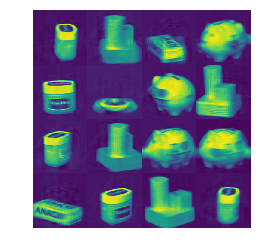

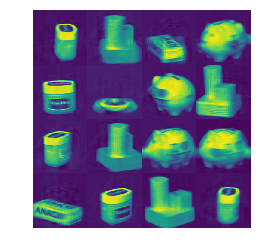

In [16]:
plot(x_recon[:1000], y_train[:1000])

# ANALYSIS

In [24]:
f = partial(svg.generate_from_samples, return_mu_sigma=True)#, normalize_cov=0.)
def walk(f, x_arr, branch_factor=20, n_steps=10, max_size=5000):
    p = np.random.permutation(len(x_arr))[:max_size]
    x_arr = x_arr[p]
    orig_shape = (-1,) + (x_arr.shape[1:])
    for i in range(n_steps):
        x_arr = np.array([x_arr] * branch_factor).reshape(orig_shape)
        (x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc) = f(x_arr)
        p = np.random.permutation(len(x_arr))[:max_size]
        x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc = x_arr[p], z_mu[p], z_sigma_v[p], z_sigma_lam[p], _x_enc[p]
        x_arr = x_arr.reshape(orig_shape)
    
    p = np.random.permutation(len(x_arr))[:max_size]
    x_arr = x_arr[p]
        
    return x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc

# NOW GENERATE all data points
max_size = min(1000, len(x_train))
x_arrs = []
test_size = len(x_train)
n_ = 0
while n_ < test_size:
    p = np.random.permutation(len(x_test))[:200]
    x_test_sample = x_test[p]
    x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc = walk(f, x_test_sample, n_steps=4, branch_factor=2, max_size=max_size)
    x_arrs.append(x_arr)
    n_ += len(x_arr)
    print("generated {}/{} points".format(n_, test_size), _x_enc.shape, x_arr.shape)

x_gens = np.concatenate(x_arrs, axis=0)[:len(x_train)]

# COMPUTE GROMOV-WASSERSTEIN
gw = gromorov_wasserstein_d(x_train, x_gens)

# COMPUTE BILIP CONSTANT
Ks = bilip(_x_enc, x_arr, 100)
print('Mean bi-Lipschitz constant: {:.4f} +- {:.4f}'.format(np.mean(Ks), np.std(Ks)))
print('Gromov-wasserstein distance: {:.4f}'.format(gw))

generated 360/360 points (360, 10) (360, 16384)
Mean bi-Lipschitz constant: 89.3119 +- 26.5253
Gromov-wasserstein distance: 0.0162


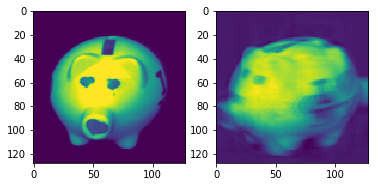

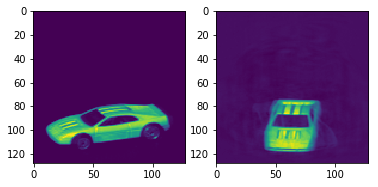

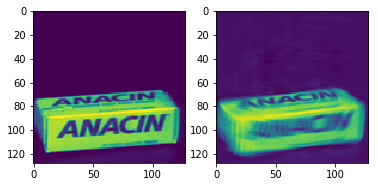

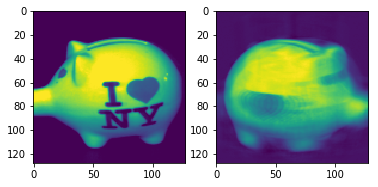

<Figure size 432x288 with 0 Axes>

In [25]:
# pick subset size
n_p = min(1000, len(x_train))
p = np.random.permutation(len(x_train))[:n_p]
x_train_p = x_train[p]
y_train_p = y_train[p]

# plot generated points
x_gen = svg.generate_from_samples(x_train_p, normalize_cov=False)
g = plot(x_gen, y_train_p, x2=x_train_p, s2=0)
p_train = np.random.permutation(len(x_train))[:n_p]

### RANDOM WALK TESTING

In [ ]:
p = np.random.permutation(len(x_test))[:1]
x_test_sample = x_test[p]
print('random walking on {}'.format(y_test[p]))
x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc = walk(f, x_test_sample, n_steps=10)

random walking on [3.]


In [ ]:
p = np.random.permutation(len(x_arr))
x_true_n_gen = np.concatenate([x_test_sample, x_arr[p]], axis=0)
g = plot(x_true_n_gen, shuffle=False)

In [ ]:
g, ax = plot(x_arr, x2=x_test, label1='predicted', label2='true', alpha2=0.2)
plt.title('predicted vs true points in data space')

In [ ]:
g = plot(z_mu, x2=f(x_test)[1], label1='predicted', label2='true')
plt.title('predicted vs true points in latent space')

In [ ]:
g = plot(x_arr, x2=x_test_sample, label1='predicted', label2='seed point', s2=1000)
plt.title('predicted vs initial seed point in data space')

In [ ]:
g = plot(z_mu, x2=f(x_test_sample)[1], label1='predicted', label2='seed point', s2=1000)
plt.title('predicted vs initial seed point in latent space')